# YOLOv8 Nightshift

## Dataset

> [Teledyne FLIR Free ADAS Thermal Dataset v2](https://adas-dataset-v2.flirconservator.com/#multipartdownloadsection):
> The Teledyne FLIR free starter thermal dataset provides fully annotated thermal and visible spectrum frames for development of object detection neural networks. This data was constructed to encourage research on visible + thermal spectrum sensor fusion algorithms ("RGBT") in order to advance the safety of autonomous vehicles. A total of 26,442 fully-annotated frames are included with 15 different object classes.


> __Baseline Model__: Baseline accuracy for object detection was established using the YOLOX-m neural network designed for 640 X 640 images. Both the RGB and thermal detectors were pre-trained on MSCOCO data ([YOLOX: Exceeding YOLO Series in 2021](https://arxiv.org/abs/2107.08430) and [YOLOX](https://github.com/Megvii-BaseDetection/YOLOX)). The base neural networks were trained on the training set data provided in this dataset and tested on the video test data also provided in this dataset.

In [1]:
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from tqdm import tqdm

### Dataset Exploration

In [2]:
# read in dataset
# images_themal = glob('./datasets/video_thermal_test/data/*.jpg')
# images_rgb = glob('./datasets/video_rgb_test/data/*.jpg')
images_themal = glob('/home/pride/work/AIMET/yolov8/yolov8-nightshift/datasets/video_thermal_test/images/*.jpg')
images_rgb = glob('/home/pride/work/AIMET/yolov8/yolov8-nightshift/datasets/video_rgb_test/images/*.jpg')

In [3]:
print(len(images_themal), len(images_rgb))

3749 3749


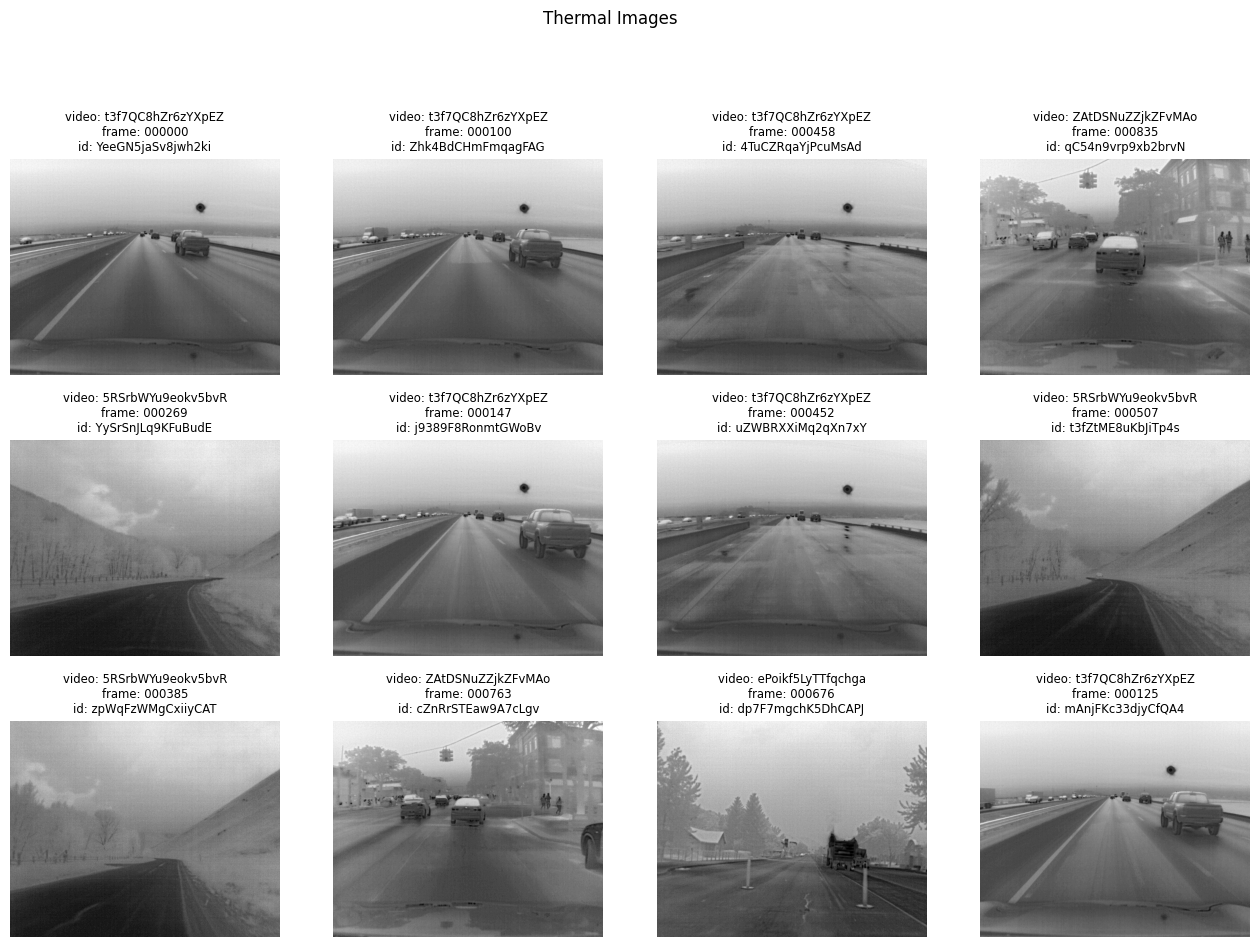

In [4]:
# plot multiple random thermal images
ran_gen = np.random.default_rng()

plt.figure(figsize=(16, 14))
plt.suptitle('Thermal Images')
for i in range(12):
    ax = plt.subplot(4, 4, i+1)
    random_index = ran_gen.integers(low=0, high=3748, size=1)
    i = random_index[0]
    img_loc = images_themal[i]
    img_title = 'video: ' + images_themal[i][-52:-35]+'\n'+ 'frame: ' + images_themal[i][-28:-22]+'\n'+ 'id: ' + images_themal[i][-21:-4]
    image = plt.imread(img_loc)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title(img_title, fontsize='small')
    plt.axis(False)

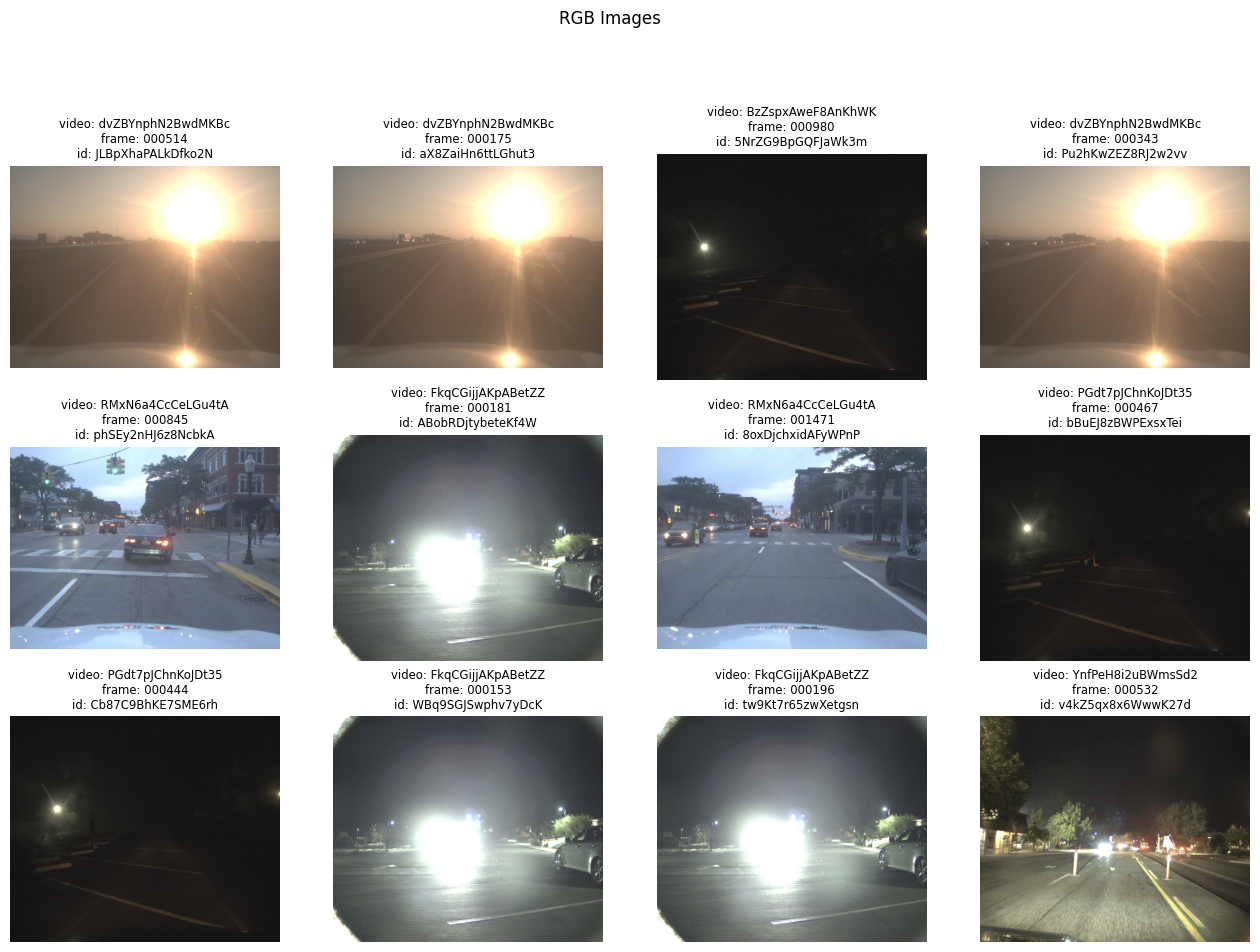

In [5]:
# plot multiple random rgb images
ran_gen = np.random.default_rng()

plt.figure(figsize=(16, 14))
plt.suptitle('RGB Images')
for i in range(12):
    ax = plt.subplot(4, 4, i+1)
    random_index = ran_gen.integers(low=0, high=3748, size=1)
    i = random_index[0]
    img_loc = images_rgb[i]
    img_title = 'video: ' + images_rgb[i][-52:-35]+'\n'+ 'frame: ' + images_rgb[i][-28:-22]+'\n'+ 'id: ' + images_rgb[i][-21:-4]
    image = plt.imread(img_loc)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.title(img_title, fontsize='small')
    plt.axis(False)

### Label Conversion JSON2YOLO

* `"file_name": "data/video-BzZspxAweF8AnKhWK-frame-000745-SSCRtAHcFjphNPczJ.jpg",` -> `"file_name": "video-BzZspxAweF8AnKhWK-frame-000745-SSCRtAHcFjphNPczJ.jpg",`

YOLOv8 expects all images to be located in an `images` dir and the txt format annotation in a `labels` folder next to it. The dataset was using a dirname of `data` for all images and had COCO JSON annotations. I renamed the folder, created the missing one and removed the "data/" from all the filenames in the JSON file. Now I am able to run a conversion:

In [6]:
def make_folders(output_path):
    if os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path)
    return output_path


def convert_bbox_coco2yolo(img_width, img_height, bbox):
    """
    Convert bounding box from COCO  format to YOLO format

    Parameters
    ----------
    img_width : int
        width of image
    img_height : int
        height of image
    bbox : list[int]
        bounding box annotation in COCO format: 
        [top left x position, top left y position, width, height]

    Returns
    -------
    list[float]
        bounding box annotation in YOLO format: 
        [x_center_rel, y_center_rel, width_rel, height_rel]
    """
    
    # YOLO bounding box format: [x_center, y_center, width, height]
    # (float values relative to width and height of image)
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

In [7]:
def convert_coco_json_to_yolo_txt(output_path, json_file):

    path = make_folders(output_path)

    with open(json_file) as f:
        json_data = json.load(f)

    # write _darknet.labels, which holds names of all classes (one class per line)
    label_file = os.path.join(output_path, "_darknet.labels")
    with open(label_file, "w") as f:
        for category in tqdm(json_data["categories"], desc="Categories"):
            category_name = category["name"]
            f.write(f"{category_name}\n")

    for image in tqdm(json_data["images"], desc="Annotation txt for each iamge"):
        img_id = image["id"]
        img_name = image["file_name"]
        img_width = image["width"]
        img_height = image["height"]

        anno_in_image = [anno for anno in json_data["annotations"] if anno["image_id"] == img_id]
        anno_txt = os.path.join(output_path, (img_name.split(".")[0]).split("/")[1] + ".txt")
        with open(anno_txt, "w") as f:
            for anno in anno_in_image:
                category = anno["category_id"]
                bbox_COCO = anno["bbox"]
                x, y, w, h = convert_bbox_coco2yolo(img_width, img_height, bbox_COCO)
                f.write(f"{category} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    print("Converting COCO Json to YOLO txt finished!")

#### Video RGB Test Dataset

In [8]:
convert_coco_json_to_yolo_txt("./datasets/video_rgb_test/labels", "./datasets/video_rgb_test/coco.json")

Annotation txt for each iamge: 100%|██████████| 3749/3749 [00:30<00:00, 124.04it/s]

Converting COCO Json to YOLO txt finished!


#### Video Thermal Test Dataset

In [9]:
convert_coco_json_to_yolo_txt("./datasets/video_thermal_test/labels", "./datasets/video_thermal_test/coco.json")

Annotation txt for each iamge: 100%|██████████| 3749/3749 [00:14<00:00, 264.65it/s]

Converting COCO Json to YOLO txt finished!


#### Images RGB Train Dataset

In [10]:
convert_coco_json_to_yolo_txt("./datasets/images_rgb_train/labels", "./datasets/images_rgb_train/coco.json")

Annotation txt for each iamge: 100%|██████████| 10318/10318 [02:54<00:00, 59.16it/s]

Converting COCO Json to YOLO txt finished!


#### Images Thermal Train Dataset

In [11]:
convert_coco_json_to_yolo_txt("./datasets/images_thermal_train/labels", "./datasets/images_thermal_train/coco.json")

Annotation txt for each iamge: 100%|██████████| 10742/10742 [02:45<00:00, 64.76it/s]

Converting COCO Json to YOLO txt finished!


#### Images RGB Val Dataset

In [12]:
convert_coco_json_to_yolo_txt("./datasets/images_rgb_val/labels", "./datasets/images_rgb_val/coco.json")

Annotation txt for each iamge: 100%|██████████| 1085/1085 [00:00<00:00, 2236.23it/s]

Converting COCO Json to YOLO txt finished!


#### Images Thermal Val Dataset

In [13]:
convert_coco_json_to_yolo_txt("./datasets/images_thermal_val/labels", "./datasets/images_thermal_val/coco.json")

Annotation txt for each iamge: 100%|██████████| 1144/1144 [00:00<00:00, 2293.21it/s]

Converting COCO Json to YOLO txt finished!


### Dataset Configuration

The `coco.yaml` file that came with the dataset contained all 80 COCO classes - I removed all classes that were not part of the annotation and assigned new `category_id`'s from `0`-`15` for the 16 categories. If you want to use the configuration files below to train your YOLO model you need to replace the annotations accordingly - check the `./config` folder.


* `config/data_thermal.yaml`

```yaml
train: ../images_thermal_train/images
val: ../images_thermal_val/images
test: ../video_thermal_test/images

nc: 16
names: [
  'person',
  'bike',
  'car',
  'motor',
  'bus',
  'train',
  'truck',
  'light',
  'hydrant',
  'sign',
  'dog',
  'deer',
  'skateboard',
  'stroller',
  'scooter',
  'other vehicle'
  ]
```

* `config/data_rgb.yaml`

```yaml
train: /opt/app/datasets/images_rgb_train/images
val: /opt/app/datasets/images_rgb_val/images
test: /opt/app/datasets/video_rgb_test/images

nc: 16
names: [
  'person',
  'bike',
  'car',
  'motor',
  'bus',
  'train',
  'truck',
  'light',
  'hydrant',
  'sign',
  'dog',
  'deer',
  'skateboard',
  'stroller',
  'scooter',
  'other vehicle'
  ]
```

In [14]:
f_rgb = open('./config/images_rgb_val_coco.json') # =>'./datasets/images_rgb_val/coco.json'
f_thermal = open('./config/images_thermal_val_coco.json') # => './datasets/images_thermal_val/coco.json'
# returns JSON object as a dictionary
data_rgb_val = json.load(f_rgb)
data_thermal_val = json.load(f_thermal)
# closing files
f_rgb.close()
f_thermal.close()

In [15]:
f_rgb = open('./config/images_rgb_train_coco.json') # => './datasets/images_rgb_train/coco.json'
f_thermal = open('./config/images_thermal_train_coco.json') # => './datasets/images_thermal_train/coco.json'
# returns JSON object as a dictionary
data_rgb_train = json.load(f_rgb)
data_thermal_train = json.load(f_thermal)
# closing files
f_rgb.close()
f_thermal.close()

In [16]:
f_rgb = open('./config/video_rgb_test_coco.json') # => './datasets/video_rgb_test/coco.json'
f_thermal = open('./config/video_thermal_test_coco.json') # => './datasets/video_thermal_test/coco.json'
# returns JSON object as a dictionary
data_rgb_test = json.load(f_rgb)
data_thermal_test = json.load(f_thermal)
# closing files
f_rgb.close()
f_thermal.close()

In [17]:
# Iterating through the json list - check that all annotations are between 0 and 15

categories = []

for detection in data_rgb_val['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  5  6  8  9 12 13 15]


In [18]:
categories = []

for detection in data_thermal_val['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  5  6  8  9 12 13 15]


In [19]:
categories = []

for detection in data_rgb_train['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  5  6  8  9 12 13 14 15]


In [20]:
categories = []

for detection in data_thermal_train['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  5  6  8  9 10 11 12 13 14 15]


In [21]:
categories = []

for detection in data_rgb_test['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  6  7  8  9 10 15]


In [22]:
categories = []

for detection in data_thermal_test['annotations']:
    categories.append(detection['category_id'])

print(np.unique(categories))

[ 0  1  2  3  6  8  9 10 15]
